In [1]:
import os
import torch
import torch.nn as nn
import torchaudio
import torchvision.transforms as T
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
# DINOv2 Base is powerful but heavy.
# If you run out of memory, lower BATCH_SIZE to 2 or 4.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv" 
DINO_MODEL_NAME = "facebook/dinov2-small" 
BATCH_SIZE = 8  
LEARNING_RATE = 1e-5 
EPOCHS = 30

print(f"🚀 Running DINOv2 on: {DEVICE}")

c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Running DINOv2 on: cuda


In [2]:
class DinoDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        
        # 1. Audio Transforms (Waveform -> Spectrogram)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            win_length=1024,
            hop_length=160,
            n_mels=128
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()
        
        # 2. Image Transforms (Spectrogram -> DINO Input)
        # DINOv2 requires 224x224 input size
        self.resize = T.Resize((224, 224)) 
        
        # Standard ImageNet normalization (Required for DINO)
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['file_path']
        
        # A. Load Audio
        try:
            waveform, sr = torchaudio.load(file_path)
        except:
            # Fallback for broken files
            waveform = torch.zeros(1, 16000*3)
            sr = 16000
            
        # Resample to 16kHz if needed
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
            
        # B. Generate Spectrogram
        spec = self.mel_transform(waveform)
        spec = self.db_transform(spec)
        
        # Resize to 224x224
        img = self.resize(spec)
        
        # C. Convert 1 Channel (Greyscale) -> 3 Channels (RGB)
        # DINO expects 3 color channels
        img = img.repeat(3, 1, 1)
        
        # Normalize to 0-1 range first
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        
        # Apply ImageNet normalization
        img = self.normalize(img)
        
        # Label
        label = torch.tensor(row['label_encoded'], dtype=torch.long)
        
        return img, label

In [3]:
class DinoV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Ensure we are using the small model string you set earlier
        print(f"🦖 Loading Pre-trained DINOv2: {DINO_MODEL_NAME}...")
        
        # Load the Vision Transformer backbone
        self.dino = AutoModel.from_pretrained(DINO_MODEL_NAME)
        
        # Freeze backbone
        for param in self.dino.parameters():
            param.requires_grad = False
            
        # --- FIX IS HERE ---
        # DINOv2-Small outputs 384. DINOv2-Base outputs 768.
        # We detect it automatically to be safe.
        hidden_size = self.dino.config.hidden_size 
        print(f"📏 Detected Hidden Size: {hidden_size}")
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512), # Uses 384 automatically
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, images):
        outputs = self.dino(pixel_values=images)
        
        # Extract CLS token
        cls_token = outputs.pooler_output
        if cls_token is None:
            cls_token = outputs.last_hidden_state[:, 0]
            
        logits = self.classifier(cls_token)
        return logits

In [4]:
# 1. Load Master CSV
full_df = pd.read_csv(SFM_CSV)

# 2. Encode Labels
label_encoder = LabelEncoder()
full_df['label_encoded'] = label_encoder.fit_transform(full_df['label_name'])
NUM_CLASSES = len(label_encoder.classes_)
print(f"📋 Classes: {label_encoder.classes_}")

# 3. Create Datasets & Loaders
train_ds = DinoDataset(full_df[full_df['split'] == 'train'])
val_ds = DinoDataset(full_df[full_df['split'] == 'val'])
test_ds = DinoDataset(full_df[full_df['split'] == 'test'])

# Note: Drop_last=True helps with BatchNorm stability in small batches
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# 4. Initialize Model
dino_model = DinoV2Classifier(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(dino_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("\n🔥 Starting DINOv2 Training...")
best_val_acc = 0.0

for epoch in range(EPOCHS):
    dino_model.train()
    total_loss = 0
    
    # Training
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits = dino_model(imgs)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    
    # Validation
    dino_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = dino_model(imgs)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    val_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(dino_model.state_dict(), "best_dinov2_model.pth")
        print(f"    💾 Saved New Best Model! ({val_acc:.4f})")

print(f"\n🏆 Training Complete. Best Validation Accuracy: {best_val_acc:.4f}")

📋 Classes: ['Cysts_Structural' 'Dysarthia' 'Laryngitis' 'Vox senilis' 'parkinson'
 'spasmodische_dysphonie']
🦖 Loading Pre-trained DINOv2: facebook/dinov2-small...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


📏 Detected Hidden Size: 384

🔥 Starting DINOv2 Training...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/30 | Loss: 1.6187 | Val Acc: 0.6803
    💾 Saved New Best Model! (0.6803)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 2/30 | Loss: 1.2366 | Val Acc: 0.7332
    💾 Saved New Best Model! (0.7332)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 3/30 | Loss: 1.0930 | Val Acc: 0.7668
    💾 Saved New Best Model! (0.7668)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 4/30 | Loss: 0.9955 | Val Acc: 0.7668


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 5/30 | Loss: 0.9419 | Val Acc: 0.7957
    💾 Saved New Best Model! (0.7957)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6/30 | Loss: 0.9114 | Val Acc: 0.7933


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 7/30 | Loss: 0.8675 | Val Acc: 0.8077
    💾 Saved New Best Model! (0.8077)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 8/30 | Loss: 0.8512 | Val Acc: 0.7933


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 9/30 | Loss: 0.8161 | Val Acc: 0.8149
    💾 Saved New Best Model! (0.8149)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 10/30 | Loss: 0.7928 | Val Acc: 0.8173
    💾 Saved New Best Model! (0.8173)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 11/30 | Loss: 0.7845 | Val Acc: 0.8269
    💾 Saved New Best Model! (0.8269)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 12/30 | Loss: 0.7658 | Val Acc: 0.8221


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 13/30 | Loss: 0.7522 | Val Acc: 0.8197


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 14/30 | Loss: 0.7384 | Val Acc: 0.8221


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 15/30 | Loss: 0.7267 | Val Acc: 0.8245


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 16/30 | Loss: 0.7011 | Val Acc: 0.8245


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 17/30 | Loss: 0.7000 | Val Acc: 0.8197


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 18/30 | Loss: 0.7050 | Val Acc: 0.8197


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 19/30 | Loss: 0.6735 | Val Acc: 0.8245


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 20/30 | Loss: 0.6735 | Val Acc: 0.8173


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 21/30 | Loss: 0.6715 | Val Acc: 0.8293
    💾 Saved New Best Model! (0.8293)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 22/30 | Loss: 0.6442 | Val Acc: 0.8341
    💾 Saved New Best Model! (0.8341)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 23/30 | Loss: 0.6472 | Val Acc: 0.8317


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True

Epoch 24/30 | Loss: 0.6425 | Val Acc: 0.8317
Epoch 25/30 | Loss: 0.6248 | Val Acc: 0.8269


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 26/30 | Loss: 0.6192 | Val Acc: 0.8317


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 27/30 | Loss: 0.6297 | Val Acc: 0.8389
    💾 Saved New Best Model! (0.8389)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 28/30 | Loss: 0.6109 | Val Acc: 0.8389


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 29/30 | Loss: 0.5906 | Val Acc: 0.8413
    💾 Saved New Best Model! (0.8413)


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 30/30 | Loss: 0.6037 | Val Acc: 0.8413

🏆 Training Complete. Best Validation Accuracy: 0.8413


🔄 Loading Best DINOv2 Model...
🚀 Evaluating on Test Set...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



🏆 Final Test Accuracy: 84.96%

📝 Detailed Classification Report:
                        precision    recall  f1-score   support

      Cysts_Structural       0.48      0.55      0.51        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.54      0.93      0.68        42
           Vox senilis       0.86      0.69      0.77        93
             parkinson       0.97      0.95      0.96       200
spasmodische_dysphonie       0.89      0.40      0.55        20

              accuracy                           0.85       419
             macro avg       0.79      0.75      0.75       419
          weighted avg       0.88      0.85      0.85       419



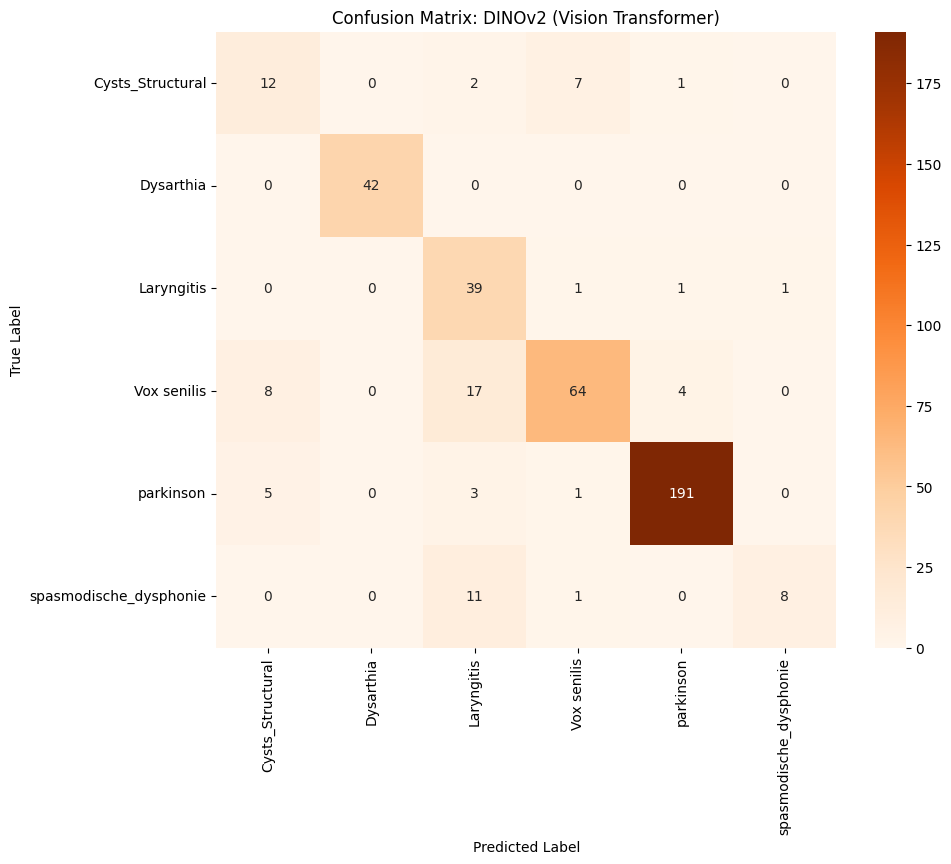

In [5]:
# 1. Load Best Model
print("🔄 Loading Best DINOv2 Model...")
dino_model.load_state_dict(torch.load("best_dinov2_model.pth"))
dino_model.eval()

# 2. Run Inference on Test Set
all_preds = []
all_labels = []

print("🚀 Evaluating on Test Set...")
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = dino_model(imgs)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Metrics
acc = accuracy_score(all_labels, all_preds)
print(f"\n🏆 Final Test Accuracy: {acc*100:.2f}%")

print("\n📝 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 4. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: DINOv2 (Vision Transformer)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

⚔️ Initializing Titan Ensemble on cuda...
📂 preparing Data...
🔄 Loading Trained Models...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🤖 Running Dual-Stream Inference...
🦖 Running DINOv2 Inference...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



🏆 TITAN ENSEMBLE Accuracy: 89.26%
------------------------------------------------------------
                        precision    recall  f1-score   support

      Cysts_Structural       0.67      0.64      0.65        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.65      0.86      0.74        42
           Vox senilis       0.86      0.83      0.84        93
             parkinson       0.98      0.98      0.98       200
spasmodische_dysphonie       0.82      0.45      0.58        20

              accuracy                           0.89       419
             macro avg       0.83      0.79      0.80       419
          weighted avg       0.90      0.89      0.89       419



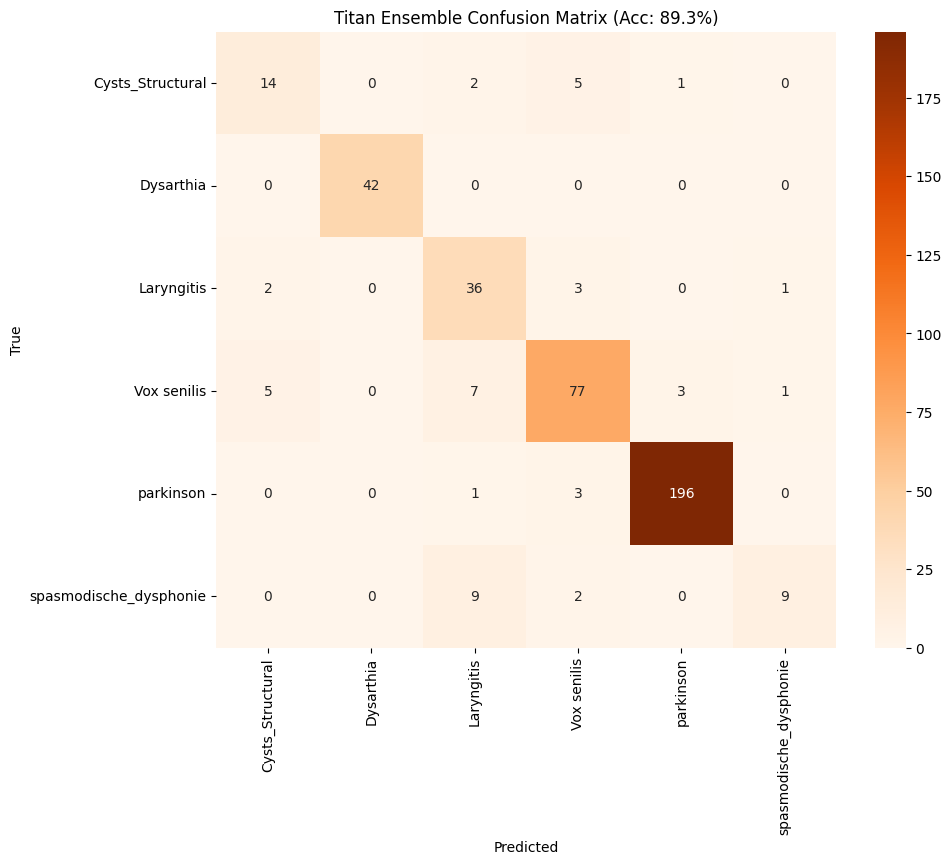

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchaudio
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv"
BATCH_SIZE = 8
NUM_CLASSES = 6
DINO_MODEL_NAME = "facebook/dinov2-small" # Must match what you trained with

print(f"⚔️ Initializing Titan Ensemble on {DEVICE}...")

# ==========================================
# 1. DEFINE DATASETS (Both Types)
# ==========================================

# A. Dual-Stream Dataset (Audio + Physics)
class VoicePathologyDataset(Dataset):
    def __init__(self, df, sfm_scaler, sfm_cols):
        self.df = df.reset_index(drop=True)
        self.sfm_scaler = sfm_scaler
        self.sfm_cols = sfm_cols
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['file_path']
        raw_sfm = row[self.sfm_cols].values.astype(np.float32)
        norm_sfm = self.sfm_scaler.transform([raw_sfm])[0]
        sfm_tensor = torch.tensor(norm_sfm, dtype=torch.float32)
        label = torch.tensor(row['label_encoded'], dtype=torch.long)
        return file_path, sfm_tensor, label

def dual_collate(batch):
    paths = [item[0] for item in batch] 
    sfms = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return paths, sfms, labels

# B. DINO Dataset (High-Res Images)
class DinoDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=1024, win_length=1024, hop_length=160, n_mels=128
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((224, 224))
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: waveform, sr = torchaudio.load(row['file_path'])
        except: waveform = torch.zeros(1, 16000*3); sr=16000
        if sr != 16000: waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
        img = self.resize(self.db_transform(self.mel_transform(waveform)))
        img = img.repeat(3, 1, 1) # 1ch -> 3ch
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        img = self.normalize(img)
        label = torch.tensor(row['label_encoded'], dtype=torch.long)
        return img, label

# ==========================================
# 2. DEFINE MODELS
# ==========================================

# A. Dual-Stream Model
class DualStreamModel(nn.Module):
    def __init__(self, num_classes, sfm_dim=10, fusion_dim=512):
        super().__init__()
        self.audio_encoder = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True)
        self.audio_proj = nn.Linear(768, fusion_dim)
        self.sfm_mlp = nn.Sequential(
            nn.Linear(sfm_dim, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, fusion_dim), nn.LayerNorm(fusion_dim)
        )
        self.cross_attn = nn.MultiheadAttention(embed_dim=fusion_dim, num_heads=8, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(fusion_dim, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, num_classes))

    def forward(self, audio_paths, sfm_input):
        audio_feats = torch.stack([self.audio_encoder(p) for p in audio_paths]).to(self.audio_proj.weight.device)
        batch_size = audio_feats.shape[0]
        audio_feats = audio_feats.view(batch_size, 768, -1).permute(0, 2, 1)
        audio_emb = self.audio_proj(audio_feats) 
        sfm_emb = self.sfm_mlp(sfm_input) 
        attn_out, _ = self.cross_attn(query=sfm_emb.unsqueeze(1), key=audio_emb, value=audio_emb)
        return self.classifier(attn_out.squeeze(1)), None

# B. DINOv2 Model (With Safe Size Detection)
class DinoV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.dino = AutoModel.from_pretrained(DINO_MODEL_NAME)
        hidden_size = self.dino.config.hidden_size # Auto-detect 384 or 768
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512), nn.ReLU(), nn.BatchNorm1d(512), 
            nn.Dropout(0.4), nn.Linear(512, num_classes)
        )
    def forward(self, images):
        outputs = self.dino(pixel_values=images)
        cls_token = outputs.pooler_output if outputs.pooler_output is not None else outputs.last_hidden_state[:, 0]
        return self.classifier(cls_token)

# ==========================================
# 3. SETUP DATA & LOADERS
# ==========================================
print("📂 preparing Data...")
full_df = pd.read_csv(SFM_CSV)
label_encoder = LabelEncoder()
full_df['label_encoded'] = label_encoder.fit_transform(full_df['label_name'])
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)

# Scaler for Dual-Stream
sfm_cols = ['jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3', 'hnr', 'f1', 'f2', 'f3', 'f4', 'f0_mean']
scaler = StandardScaler()
scaler.fit(full_df[full_df['split'] == 'train'][sfm_cols].values)

# Create Loaders
ds_dual = VoicePathologyDataset(test_df, scaler, sfm_cols)
loader_dual = DataLoader(ds_dual, batch_size=BATCH_SIZE, shuffle=False, collate_fn=dual_collate)

ds_dino = DinoDataset(test_df)
loader_dino = DataLoader(ds_dino, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 4. LOAD WEIGHTS & INFERENCE
# ==========================================
print("🔄 Loading Trained Models...")

# Load Dual-Stream
model_dual = DualStreamModel(num_classes=NUM_CLASSES).to(DEVICE)
model_dual.load_state_dict(torch.load(r"DualStream\Models\WeightedDualStream\best_weighted_model.pth"))
model_dual.eval()

# Load DINOv2
model_dino = DinoV2Classifier(num_classes=NUM_CLASSES).to(DEVICE)
model_dino.load_state_dict(torch.load("best_dinov2_model.pth"))
model_dino.eval()

probs_dual = []
probs_dino = []
true_labels = []

print("🤖 Running Dual-Stream Inference...")
with torch.no_grad():
    for paths, sfms, labels in loader_dual:
        sfms = sfms.to(DEVICE)
        logits, _ = model_dual(paths, sfms)
        probs_dual.append(F.softmax(logits, dim=1).cpu().numpy())
        true_labels.append(labels.numpy())

print("🦖 Running DINOv2 Inference...")
with torch.no_grad():
    for imgs, _ in loader_dino:
        imgs = imgs.to(DEVICE)
        logits = model_dino(imgs)
        probs_dino.append(F.softmax(logits, dim=1).cpu().numpy())

# Concatenate
probs_dual = np.concatenate(probs_dual)
probs_dino = np.concatenate(probs_dino)
true_labels = np.concatenate(true_labels)

# ==========================================
# 5. ENSEMBLE CALCULATION
# ==========================================
# Weighted Vote: 40% Dual-Stream (Physics), 60% DINO (Vision)
final_probs = (0.4 * probs_dual) + (0.6 * probs_dino)
final_preds = np.argmax(final_probs, axis=1)

# ==========================================
# 6. RESULTS
# ==========================================
acc = accuracy_score(true_labels, final_preds)
print(f"\n🏆 TITAN ENSEMBLE Accuracy: {acc*100:.2f}%")
print("-" * 60)
print(classification_report(true_labels, final_preds, target_names=label_encoder.classes_))

# Plot Matrix
cm = confusion_matrix(true_labels, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f'Titan Ensemble Confusion Matrix (Acc: {acc*100:.1f}%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()